In [391]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import imageio
import tensorflow as tf 
import os
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from IPython.display import clear_output
clear_output()

In [392]:
DATA_DIR = '../input/breast-cancer-masked-images/Benign_Dataset/'

In [393]:
os.listdir(DATA_DIR)

['label', 'data']

In [394]:
image_path = DATA_DIR+'data/'
mask_path = DATA_DIR+'label/'
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in sorted(image_list)]
mask_list = [mask_path+i for i in sorted(mask_list)]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Segmentation')

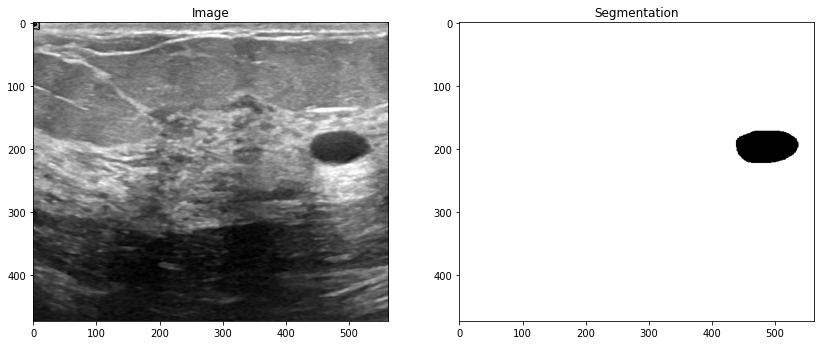

In [395]:
N = 3
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])
norm = BoundaryNorm([0, 1], 2)
fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img, norm = norm )
arr[0].set_title('Image')
arr[1].imshow(mask, cmap='binary')
arr[1].set_title('Segmentation')

In [396]:
image_list_ds = tf.data.Dataset.list_files(sorted(image_list), shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(sorted(mask_list), shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)
    

(<tf.Tensor: shape=(), dtype=string, numpy=b'../input/breast-cancer-masked-images/Benign_Dataset/data/benign (1).png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'../input/breast-cancer-masked-images/Benign_Dataset/label/benign (1)_mask.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'../input/breast-cancer-masked-images/Benign_Dataset/data/benign (10).png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'../input/breast-cancer-masked-images/Benign_Dataset/label/benign (10)_mask.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'../input/breast-cancer-masked-images/Benign_Dataset/data/benign (100).png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'../input/breast-cancer-masked-images/Benign_Dataset/label/benign (100)_mask.png'>)


In [397]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'../input/breast-cancer-masked-images/Benign_Dataset/data/benign (1).png', shape=(), dtype=string)
tf.Tensor(b'../input/breast-cancer-masked-images/Benign_Dataset/label/benign (1)_mask.png', shape=(), dtype=string)


In [398]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = 255 - img
    img = tf.image.convert_image_dtype(img, tf.float32)
    #img = tf.math.reduce_max(img, axis=-1, keepdims=True)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = 255 - mask
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    input_image = input_image / 255
    input_mask = input_mask / 255

    return input_image, input_mask

In [399]:
image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [400]:
image_ds

<MapDataset shapes: ((None, None, 3), (None, None, 1)), types: (tf.float32, tf.uint8)>

In [401]:
processed_image_ds

<MapDataset shapes: ((96, 128, 3), (96, 128, 1)), types: (tf.float32, tf.float32)>

In [402]:
for image, mask in processed_image_ds.take(1):
    print(image)
    print(mask)

tf.Tensor(
[[[0.00378316 0.00378316 0.00378316]
  [0.00070742 0.00070742 0.00070742]
  [0.00099962 0.00099962 0.00099962]
  ...
  [0.00052288 0.00052288 0.00052288]
  [0.00090734 0.00090734 0.00090734]
  [0.00073818 0.00073818 0.00073818]]

 [[0.0035371  0.0035371  0.0035371 ]
  [0.00392157 0.00392157 0.00392157]
  [0.00370627 0.00370627 0.00370627]
  ...
  [0.00127643 0.00127643 0.00127643]
  [0.00121492 0.00121492 0.00121492]
  [0.00127643 0.00127643 0.00127643]]

 [[0.00390619 0.00390619 0.00390619]
  [0.0016609  0.0016609  0.0016609 ]
  [0.00184544 0.00184544 0.00184544]
  ...
  [0.00138408 0.00138408 0.00138408]
  [0.00143022 0.00143022 0.00143022]
  [0.00156863 0.00156863 0.00156863]]

 ...

 [[0.00350634 0.00350634 0.00350634]
  [0.00347559 0.00347559 0.00347559]
  [0.00355248 0.00355248 0.00355248]
  ...
  [0.00358324 0.00358324 0.00358324]
  [0.00367551 0.00367551 0.00367551]
  [0.00350634 0.00350634 0.00350634]]

 [[0.00359862 0.00359862 0.00359862]
  [0.00346021 0.00346021 0

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


In [403]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer = 'he_normal')(inputs)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer = 'he_normal')(conv)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    if max_pooling:
         next_layer = MaxPooling2D((2, 2), strides=2)(conv)
    else:
        next_layer = conv
    skip_connection = conv
    
    return next_layer, skip_connection

In [404]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    conv_transpose = Conv2DTranspose(n_filters, 3, strides=2, padding='same')(expansive_input)
    merge = concatenate([conv_transpose, contractive_input], axis=3)
    
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(merge)
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    
    return conv

In [405]:
def unet_model(input_size=(96,128,1), n_filters=32, n_classes=1):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    #Normalized_Input = tf.keras.layers.Lambda(lambda Pixel: Pixel/255)(inputs)
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    # Include a dropout of 0.3 for this layer
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8,dropout_prob=0.3)
    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16,dropout_prob=0.3, max_pooling=False) 
    ### END CODE HERE
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # From here,at each step, use half the number of filters of the previous block 
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ### START CODE HERE
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)
    ### END CODE HERE

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    ### START CODE HERE
    conv10 = Conv2D(n_classes, 1, padding='same', activation='softmax')(conv9)
    ### END CODE HERE
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model
    

In [406]:
img_height = 96
img_width = 128
num_channels = 3

In [407]:
unet = unet_model((img_height, img_width, num_channels))

In [408]:
unet.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_300 (Conv2D)             (None, 96, 128, 32)  896         input_16[0][0]                   
__________________________________________________________________________________________________
conv2d_301 (Conv2D)             (None, 96, 128, 32)  9248        conv2d_300[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_60 (MaxPooling2D) (None, 48, 64, 32)   0           conv2d_301[0][0]                 
___________________________________________________________________________________________

In [409]:
unet.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [410]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='binary')
        plt.axis('off')
    plt.show()

(471, 562, 1)


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


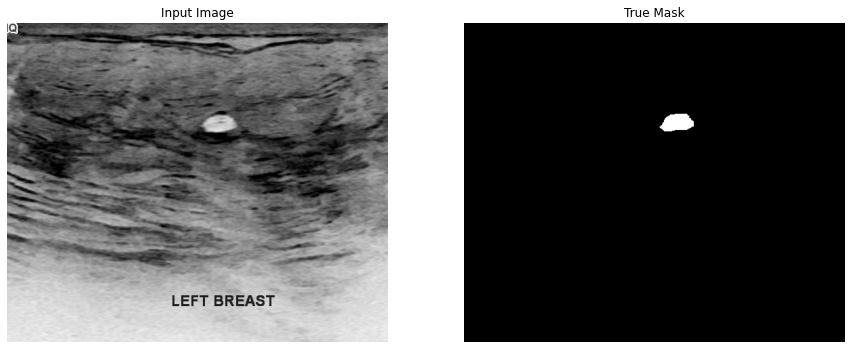

In [411]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


(96, 128, 1)


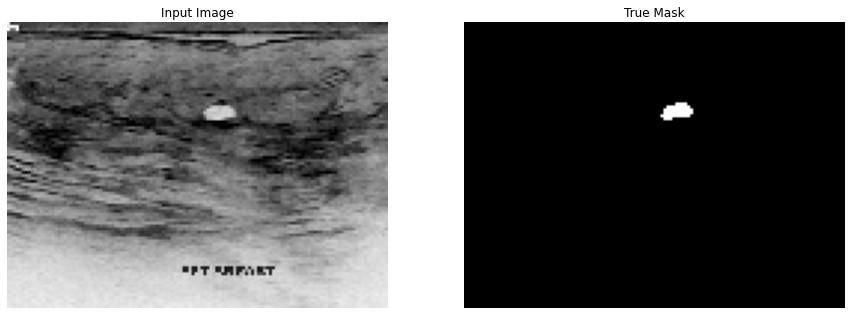

In [412]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [413]:
EPOCHS = 10
VAL_SUBSPLITS = 5
BUFFER_SIZE = 1000
BATCH_SIZE = 64
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#print(processed_image_ds.element_spec)

In [414]:
print(processed_image_ds.element_spec)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.float32, name=None))


In [ ]:
model_history = unet.fit(train_dataset, epochs=EPOCHS)

In [416]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [417]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

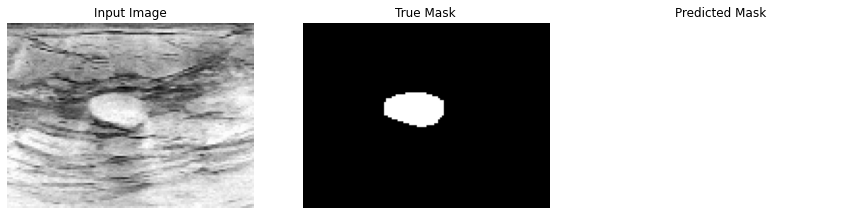

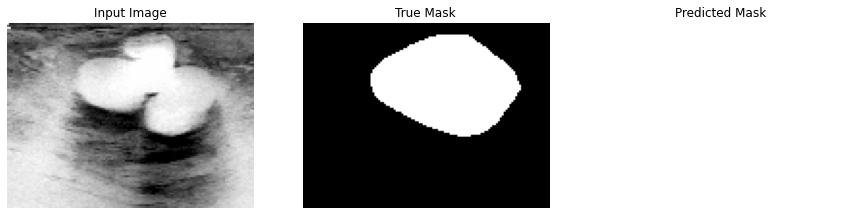

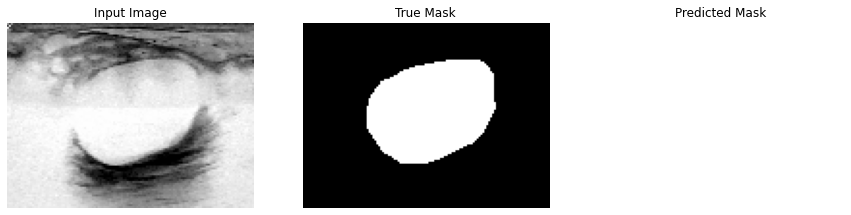

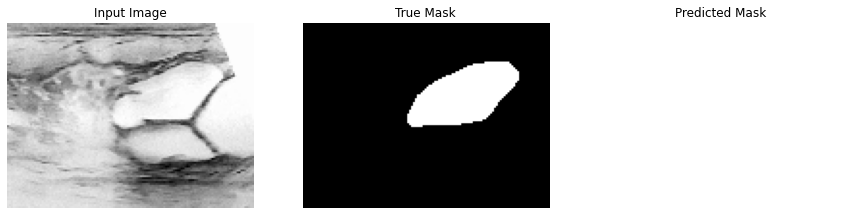

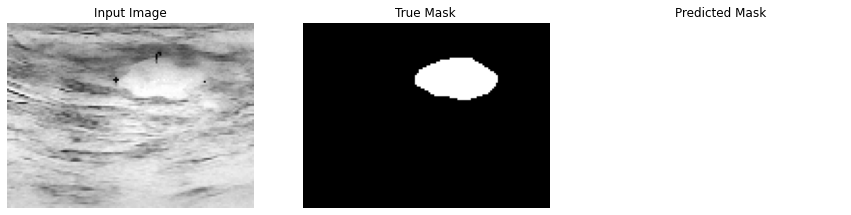

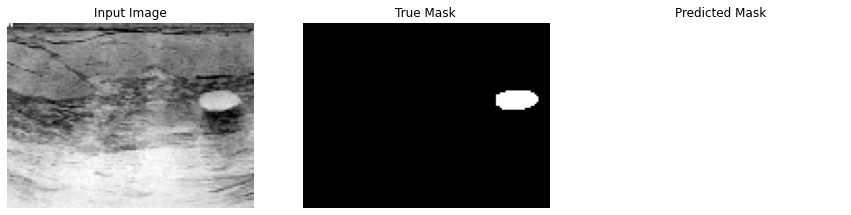

In [420]:
show_predictions(train_dataset, 6)